# NYC Uber Location Analysis
### Saloni Sharma

*** 
## Import libraries and files

In [1]:
#Import all libraries
import pandas as pd
import numpy as np
import descartes
import geopandas as gpd
import mapclassify as mc
from shapely.geometry import Point, Polygon
import geoplot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import all files
# Import 2014 data set
uber2014_reduced = pd.read_csv("uber14-processed.csv", parse_dates=['Date/Time']) #convert column values to datetime format

In [3]:
# Import 2015 data set
uber2015_reduced = pd.read_csv("uber15-processed.csv", parse_dates=['Pickup_date']) #convert to datetime format

In [4]:
# Import shapefile of taxi zone map
taxi_zones_map = gpd.read_file("zones_map/zones_map.shp")

In [5]:
# Import shapefile
boroughs = gpd.read_file("nyc_boroughs/nyc_boroughs.shp")

***
# Preparing Location Data
Both data sets provide information for Uber pickup locations. The 2014 data set includes latitude and longitude data. However, the 2015 data lists a location ID, which references a neighbourhood (taxi zone), for each pickup. Therefore, the 2014 location data will be grouped by the same location IDs to ensure better comparison analysis. This will be done using GeoPandas and polygon coordinates included in the NYC map shapefile, which also provides the corresponding location IDs and neighbourhoods. 

### _Uber 2014_ 
Create a GeoDataFrame with latitude and longitude included in 2014 dataset. 

In [6]:
# Create geopandas POINT values from latitude and longitude coordinates
geometry = gpd.points_from_xy(uber2014_reduced.Lon, uber2014_reduced.Lat)

In [7]:
# Drop 'Lat' and 'Lon' columns as they are no longer needed
uber2014_reduced = uber2014_reduced.drop(["Lat", "Lon"], axis=1)

In [8]:
# Create GeoDataFrame and add 'geometry' column with Points
# CRS (Coordinate Reference System) to specify Point data
# This tells Python how coordinates relate to places on the Earth
crs = {'init': 'epsg:4326'}
# Make GeoDataFrame
gdf_uber2014 = gpd.GeoDataFrame(uber2014_reduced, crs = crs, geometry = geometry)
gdf_uber2014.head()

,Date/Time,geometry
0,2014-04-01 00:00:00,POINT (-73.99520 40.72150)
1,2014-04-01 00:00:00,POINT (-73.98630 40.71880)
2,2014-04-01 00:00:00,POINT (-73.96000 40.76370)
3,2014-04-01 00:01:00,POINT (-73.99660 40.73550)
4,2014-04-01 00:02:00,POINT (-73.99640 40.74440)


In [9]:
# Combine gdf with taxi_zones_map to get locationIDs
gdf_uber2014 = gpd.sjoin(gdf_uber2014, taxi_zones_map, how="right", op='within')

In [10]:
gdf_uber2014.head()

,index_left,Date/Time,zone,locationID,geometry
index_right,,,,,
0,1545697.0,2014-06-15 15:20:00,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
0,1547606.0,2014-06-15 17:22:00,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
0,1880562.0,2014-06-30 23:18:00,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
0,1451020.0,2014-06-11 19:19:00,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
0,1566269.0,2014-06-16 19:16:00,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."


In [11]:
# Check for null entries
gdf_uber2014.isnull().sum()

index_left    6
Date/Time     6
zone          0
locationID    0
geometry      0
dtype: int64

In [12]:
# Drop entire columns with null values since they are not needed for mapping
gdf_uber2014_map = gdf_uber2014.drop(['Date/Time', 'index_left'], axis=1)

In [13]:
gdf_uber2014_map.head()

,zone,locationID,geometry
index_right,,,
0,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
0,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
0,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
0,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
0,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."


In [14]:
# Reset the indices as well
gdf_uber2014_map.reset_index(drop=True)

,zone,locationID,geometry
0,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
2,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
3,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
4,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
...,...,...,...
1847281,Freshkills Park,99,"POLYGON ((-74.16843 40.58650, -74.16895 40.583..."
1847282,Governor's Island/Ellis Island/Liberty Island,103,"POLYGON ((-74.04389 40.69018, -74.04351 40.689..."
1847283,Governor's Island/Ellis Island/Liberty Island,103,"POLYGON ((-74.03995 40.70089, -74.03945 40.700..."
1847284,Great Kills Park,110,"POLYGON ((-74.11813 40.55059, -74.11656 40.549..."


Create a new GeoDataFrame with counts of pickups in each neighbourhood and its corresponding polygon data for mapping.

In [15]:
# First, create a pandas DataFrame with the total counts of pickups per neighbourhood (locationID)
# Reindex for cases of 0 counts for certain neighbourhoods (263 total possible neighbourhoods)
gdf_uber2014_map = pd.DataFrame(gdf_uber2014_map['locationID'].value_counts().reindex(range(1,264), fill_value=0))

In [16]:
# Rename column to correct attribute
gdf_uber2014_map.rename(columns = {'locationID':'ID_Counts'}, inplace = True) 

In [17]:
gdf_uber2014_map.head()

,ID_Counts
1,13150
2,1
3,89
4,10765
5,4


In [18]:
# Make index values into an attribute column, this holds the corresponding locationIDs
gdf_uber2014_map = gdf_uber2014_map.reset_index()

In [19]:
# Rename new 'index' column to locationID
gdf_uber2014_map.rename(columns = {'index':'locationID'}, inplace = True)

In [20]:
gdf_uber2014_map.head()

,locationID,ID_Counts
0,1,13150
1,2,1
2,3,89
3,4,10765
4,5,4


In [21]:
# Join with taxi_zones_map to get polygons for locationIDs
gdf_uber2014_map = gdf_uber2014_map.merge(taxi_zones_map, on='locationID')

In [22]:
# Finally, make it into a GeoDataFrame to plot
uber2014_map = gpd.GeoDataFrame(gdf_uber2014_map, crs = crs, geometry = gdf_uber2014_map['geometry']) #crs set above

In [23]:
uber2014_map.head()

,locationID,ID_Counts,zone,geometry
0,1,13150,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,1,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,89,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,10765,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,4,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


### _Uber 2015_ 
Add 'polygon' coordinates given neighbourhood names

In [24]:
uber2015_reduced.head()

,Pickup_date,locationID
0,2015-04-01 00:01:00,158
1,2015-04-01 00:02:00,148
2,2015-04-01 00:03:00,107
3,2015-04-01 00:03:00,170
4,2015-04-01 00:03:00,237


Since the 2015 dataset only provides location IDs, the corresponding polygon information must be added in. This will be imported from the map shapefile.

In [25]:
taxi_zones_map.head()

,zone,locationID,geometry
0,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Jamaica Bay,2,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Allerton/Pelham Gardens,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Alphabet City,4,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Arden Heights,5,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [26]:
# Merge shapefile and uber dataset to get corresponding data
gdf_uber2015 = uber2015_reduced.merge(taxi_zones_map, on='locationID')
gdf_uber2015.head()

,Pickup_date,locationID,zone,geometry
0,2015-04-01 00:01:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."
1,2015-04-01 00:04:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."
2,2015-04-01 00:04:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."
3,2015-04-01 00:06:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."
4,2015-04-01 00:06:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."


In [27]:
# Set CRS information and make it into a GeoDataFrame
crs = {'init': 'epsg:4326'}
gdf_uber2015 = gpd.GeoDataFrame(gdf_uber2015, crs = crs, geometry = gdf_uber2015['geometry'])

In [28]:
gdf_uber2015.head()

,Pickup_date,locationID,zone,geometry
0,2015-04-01 00:01:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."
1,2015-04-01 00:04:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."
2,2015-04-01 00:04:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."
3,2015-04-01 00:06:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."
4,2015-04-01 00:06:00,158,Meatpacking/West Village West,"POLYGON ((-74.00779 40.74197, -74.00697 40.741..."


In a similar process to the 2014 data, create a new GeoDataFrame with counts of pickups in each neighbourhood and its corresponding polygon data for mapping.

In [29]:
# Create a pandas DataFrame with the total counts of pickups per neighbourhood (locationID)
gdf_uber2015_map = pd.DataFrame(gdf_uber2015['locationID'].value_counts().reindex(range(1,264), fill_value=0))

In [30]:
gdf_uber2015_map.head()

,locationID
1,66
2,6
3,2268
4,48823
5,21


In [31]:
# Rename column to correct attribute
gdf_uber2015_map.rename(columns = {'locationID':'ID_Counts'}, inplace = True) 

In [32]:
# Make index values into an attribute column, this holds the corresponding locationIDs
gdf_uber2015_map = gdf_uber2015_map.reset_index()

In [33]:
# Rename new 'index' column to locationID
gdf_uber2015_map.rename(columns = {'index':'locationID'}, inplace = True)

In [34]:
gdf_uber2015_map.head()

,locationID,ID_Counts
0,1,66
1,2,6
2,3,2268
3,4,48823
4,5,21


In [35]:
# Combine with taxi_zones_map to get polygons for locationIDs
gdf_uber2015_map = gdf_uber2015_map.merge(taxi_zones_map, on='locationID')

In [36]:
# Lastly, make it into a GeoDataFrame to plot
uber2015_map = gpd.GeoDataFrame(gdf_uber2015_map, crs = crs, geometry = gdf_uber2015_map['geometry']) #crs set above

In [37]:
uber2015_map.head()

,locationID,ID_Counts,zone,geometry
0,1,66,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,6,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,2268,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,48823,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,21,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


*** 
# Plotting Uber Maps
Finally, we will plot the 2014 and 2015 Uber datasets over a map of NYC. This map is plotted by a shapefile with polygons of neighbourhoods (taxi zones) in NYC. With the polygons in the Uber datasets, the maps below will show the density of pickups in each neighbourhood. Darker colors imply stronger density, while lighter colors signify lower density and fewer Uber pickups.

### _Uber 2014 Map_

In [38]:
# Create bins for few to many rides per neighbourhood
scheme_2014 = mc.FisherJenks(uber2014_map['ID_Counts'], k=30) #similar to k-means clustering for creates 'classes' of counts
scheme_2014

FisherJenks                 

      Interval         Count
----------------------------
[    1.00,   217.00] |    91
(  217.00,   511.00] |    42
(  511.00,  1107.00] |    28
( 1107.00,  2012.00] |    16
( 2012.00,  3003.00] |     7
( 3003.00,  4468.00] |     6
( 4468.00,  5832.00] |     9
( 5832.00,  8607.00] |    10
( 8607.00, 10226.00] |     5
(10226.00, 11439.00] |     2
(11439.00, 13318.00] |     3
(13318.00, 15621.00] |     5
(15621.00, 17152.00] |     3
(17152.00, 19230.00] |     2
(19230.00, 22403.00] |     4
(22403.00, 26181.00] |     3
(26181.00, 27748.00] |     1
(27748.00, 30688.00] |     2
(30688.00, 31879.00] |     1
(31879.00, 33229.00] |     2
(33229.00, 35232.00] |     2
(35232.00, 38945.00] |     3
(38945.00, 40412.00] |     3
(40412.00, 42533.00] |     3
(42533.00, 46785.00] |     1
(46785.00, 48389.00] |     3
(48389.00, 49950.00] |     3
(49950.00, 62078.00] |     1
(62078.00, 65001.00] |     1
(65001.00, 85219.00] |     1

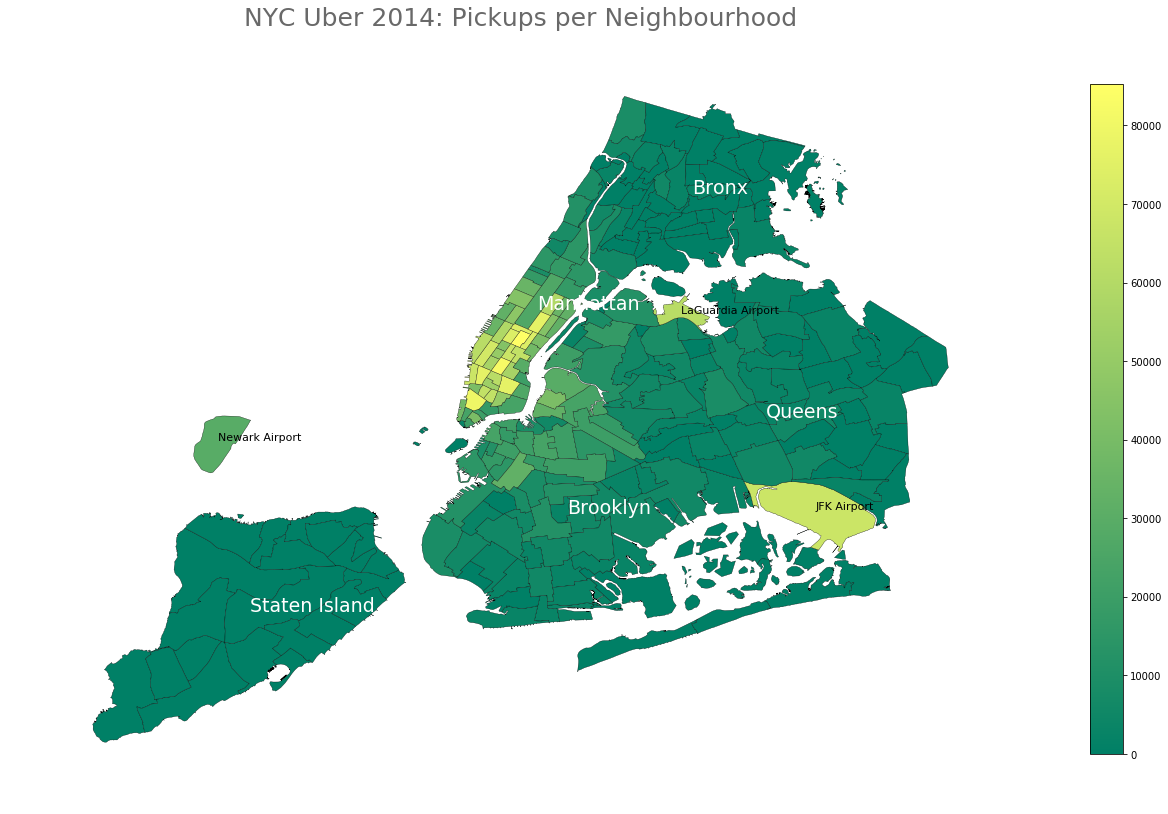

In [39]:
# Plot map with data
fig, ax = plt.subplots(1, figsize=(20, 25))
geoplot.choropleth(
    uber2014_map, hue=uber2014_map['ID_Counts'], scheme=scheme_2014,
    cmap='summer', edgecolor="Black", linewidth=0.3,
    ax=ax
    )
#Plot Borough names over map
for i, geo in boroughs.centroid.iteritems():
    ax.annotate(s=boroughs['boro_name'].iloc[i], xy=[geo.x, geo.y], color="White", fontsize=19)
#Airport names
main_areas = ['JFK Airport', 'Newark Airport', 'LaGuardia Airport']
for i, geo in uber2014_map.centroid.iteritems():
    if (uber2015_map['zone'].iloc[i] in main_areas):
        ax.annotate(s=uber2014_map['zone'].iloc[i], xy=[geo.x, geo.y], color="Black", fontsize=11)

#Plot title
ax.set_title("NYC Uber 2014: Pickups per Neighbourhood", fontsize=25, color="DimGray", fontweight=2)
ax.set_facecolor("Black")

# Color bar legend
max_rides = max(uber2014_map['ID_Counts']) #max count of rides in plot
sm = plt.cm.ScalarMappable(cmap="summer", norm=plt.Normalize(vmin=0, vmax=max_rides))
sm._A = [] # empty array for the data range
#show colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03)

In [40]:
# Export map as image file
fig.savefig("Uber2014Map.png", dpi=300)

### _Uber 2015 Map_

In [41]:
# Create bins for few to many rides per neighbourhood
scheme_2015 = mc.FisherJenks(uber2015_map['ID_Counts'], k=30) #similar to k-means clustering for creates 'classes' of counts
scheme_2015

FisherJenks                   

       Interval          Count
------------------------------
[     0.00,   1087.00] |    45
(  1087.00,   2924.00] |    44
(  2924.00,   4884.00] |    31
(  4884.00,   7853.00] |    28
(  7853.00,  11314.00] |    17
( 11314.00,  15352.00] |    10
( 15352.00,  21854.00] |     6
( 21854.00,  24386.00] |     4
( 24386.00,  29611.00] |     8
( 29611.00,  32544.00] |     6
( 32544.00,  36969.00] |     3
( 36969.00,  41901.00] |     5
( 41901.00,  46394.00] |     4
( 46394.00,  50880.00] |     3
( 50880.00,  63562.00] |     5
( 63562.00,  71248.00] |     5
( 71248.00,  77750.00] |     3
( 77750.00,  84426.00] |     4
( 84426.00,  91386.00] |     2
( 91386.00, 102538.00] |     2
(102538.00, 106960.00] |     3
(106960.00, 120674.00] |     3
(120674.00, 128247.00] |     2
(128247.00, 135581.00] |     3
(135581.00, 143719.00] |     2
(143719.00, 150317.00] |     4
(150317.00, 159476.00] |     4
(159476.00, 169788.00] |     3
(169788.00, 218569.00] |     3
(218569

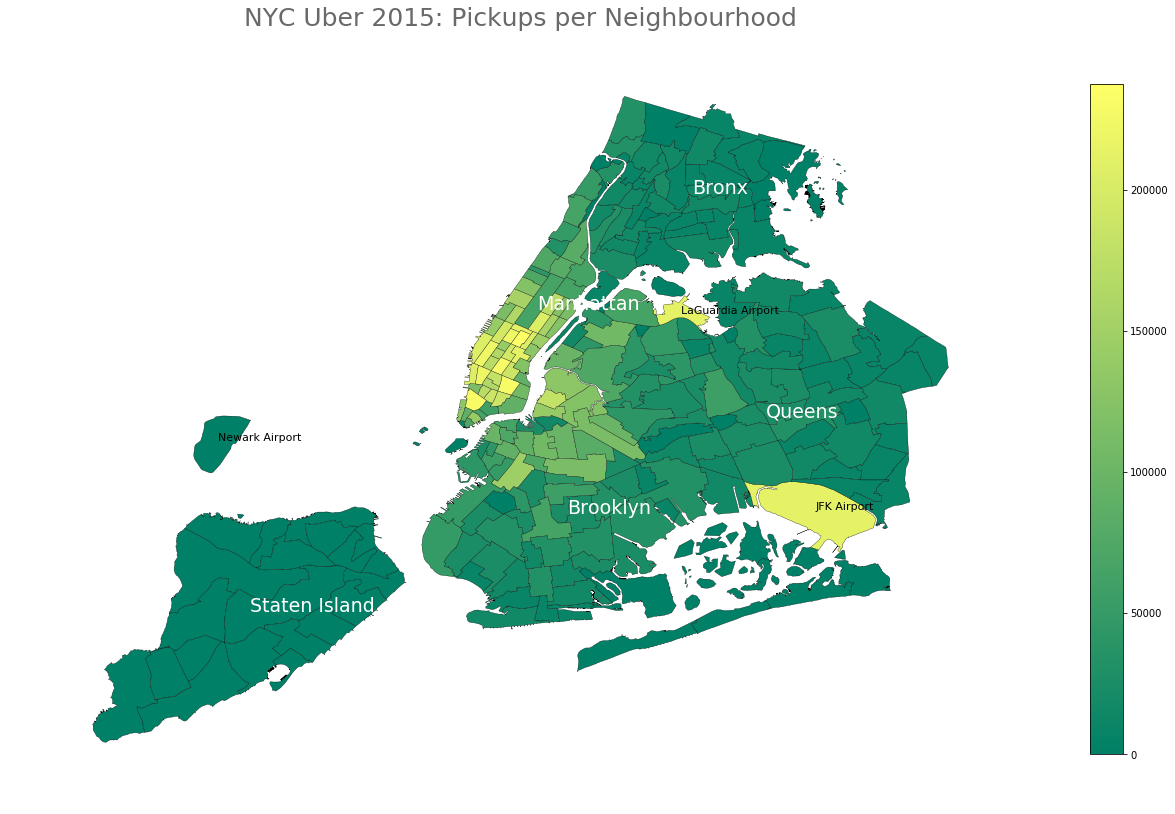

In [42]:
# Plot map with data
fig_15, ax_15 = plt.subplots(1, figsize=(20, 25))
geoplot.choropleth(
    uber2015_map, hue=uber2015_map['ID_Counts'], scheme=scheme_2015,
    cmap='summer', edgecolor="Black", linewidth=0.3,
    ax=ax_15
    )
#Plot Borough names over map
for i, geo in boroughs.centroid.iteritems():
    ax_15.annotate(s=boroughs['boro_name'].iloc[i], xy=[geo.x, geo.y], color="White", fontsize=19)

#Airport names
main_areas = ['JFK Airport', 'Newark Airport', 'LaGuardia Airport']
for i, geo in uber2015_map.centroid.iteritems():
    if (uber2015_map['zone'].iloc[i] in main_areas):
        ax_15.annotate(s=uber2015_map['zone'].iloc[i], xy=[geo.x, geo.y], color="Black", fontsize=11)

#Plot title
ax_15.set_title("NYC Uber 2015: Pickups per Neighbourhood", fontsize=25, color="DimGray", fontweight=2)
ax_15.set_facecolor("Black")

# Color bar legend
max_rides = max(uber2015_map['ID_Counts']) #max count of rides in plot
sm = plt.cm.ScalarMappable(cmap="summer", norm=plt.Normalize(vmin=0, vmax=max_rides))
sm._A = [] # empty array for the data range
#show colorbar
cbar = fig_15.colorbar(sm, ax=ax_15, orientation='vertical', fraction=0.03)

In [43]:
# Export map as image file
fig_15.savefig("Uber2015Map.png", dpi=300)